In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import keras
from models import model_v1, model_v2
tf.test.is_gpu_available()

2024-02-28 12:47:32.461925: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 12:47:32.495399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 12:47:32.495430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 12:47:32.496379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 12:47:32.501151: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-02-28 12:47:33.771178: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 12:47:33.807455: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 12:47:33.813111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

In [12]:
# dataset
from pathlib import Path
from DataGenerator import DataGenerator

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
rho = 16
train_path = Path(root) / "Phase2" / "Data" / "Train_Resize"
train_gen = DataGenerator(train_path,mode="supervised",
                          rho=rho)

# validation set
val_path = Path(root) / "Phase2" / "Data" / "Val_Resize"
val_gen = DataGenerator(val_path,mode="supervised",
                        rho=rho)


reshuffling dataset


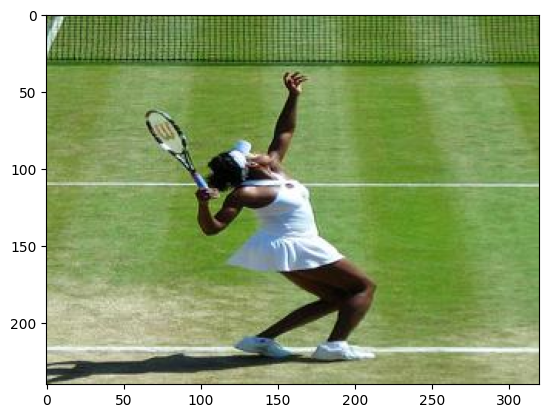

[[  0   0]
 [127   0]
 [127 127]
 [  0 127]]
[[ 12  -1]
 [121  -6]
 [118 133]
 [ -6 142]]
[-12   1   6   6   9  -6   6 -15]
[[ 1.38907894e+00  2.50786045e-02 -3.72756601e+01]
 [ 2.43262138e-01  1.34095902e+00 -6.89238979e+01]
 [ 1.10677212e-03 -1.71303126e-04  1.00000000e+00]]
[ 66 174] [ 66. 174.]
[193 174] [193. 174.]
[193 301] [193. 301.]
[ 66 301] [ 66. 301.]
(128, 128, 3) (128, 128, 3) (8,)


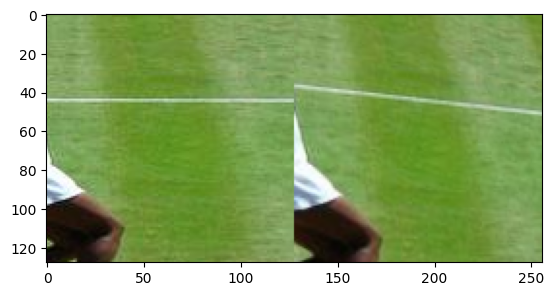

In [6]:
# test generator
sample_input, sample_output = next(train_gen(debug=True))
print(sample_input[0].shape,sample_input[1].shape,sample_output.shape)

In [20]:
# tensorflow dataset
im_shape = (train_gen.crop_size,train_gen.crop_size,3)
output_signature = ((tf.TensorSpec(shape=im_shape,dtype=tf.float32),
                     tf.TensorSpec(shape=im_shape,dtype=tf.float32)),
                     tf.TensorSpec(shape = (8,),dtype=tf.float32),
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen,
                                          output_signature=output_signature)

batch_size=16
def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

train_ds = config_ds(train_ds)
val_ds = config_ds(val_ds)

# loss function
def custom_loss(y_true, y_pred):
    return 0.5*tf.reduce_mean(tf.square(y_true-y_pred))

def metric_abs(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true-y_pred))

def metric_dist(y_true, y_pred):
    """compute the l2 distance between corner

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_
    """
    d = tf.reshape(y_true,(-1,4,2))-tf.reshape(y_pred,(-1,4,2))
    return tf.reduce_mean(tf.norm(d,ord='euclidean',axis=-1))

In [21]:
# model version 2
model = model_v2(verbose=True)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=custom_loss, metrics=[metric_abs,metric_dist])

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_6 (Functional)        (None, 32, 32, 256)          2325568   ['input_11[0][0]',            
                                                                     'input_12[0][0]']            
                                                                                                  
 concatenate_3 (Concatenate  (None, 32, 32, 512)          0         ['model_6[0][0]',       

In [22]:
import numpy as np
steps_per_epoch = int(np.floor(5000/batch_size))

# reduce learning rate on plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=5)

# save check points
checkpoint_filepath = f'./chkpt_weight/checkpoint_mdl_v2_rho{rho:2d}'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only = True,
    verbose=True,
    # save_freq = steps_per_epoch*10
    )

history = model.fit(train_ds,validation_data=val_ds,
                    validation_steps=int(np.floor(1000/batch_size)),
                    validation_freq=1,
                    epochs=150,verbose=True,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[reduce_lr,checkpoint_callback])

Epoch 1/150
312/312 [==============================] - ETA: 0s - loss: 38.9005 - metric_abs: 7.4218 - metric_dist: 11.4493reshuffling dataset

Epoch 1: val_loss improved from inf to 45.29910, saving model to ./chkpt_weight/checkpoint_mdl_v2_rho16
312/312 [==============================] - 49s 128ms/step - loss: 38.9005 - metric_abs: 7.4218 - metric_dist: 11.4493 - val_loss: 45.2991 - val_metric_abs: 7.7048 - val_metric_dist: 11.9934 - lr: 0.0010
Epoch 2/150
312/312 [==============================] - ETA: 0s - loss: 22.5878 - metric_abs: 5.3541 - metric_dist: 8.3747reshuffling dataset

Epoch 2: val_loss improved from 45.29910 to 21.18074, saving model to ./chkpt_weight/checkpoint_mdl_v2_rho16
312/312 [==============================] - 40s 127ms/step - loss: 22.5878 - metric_abs: 5.3541 - metric_dist: 8.3747 - val_loss: 21.1807 - val_metric_abs: 5.1584 - val_metric_dist: 8.0983 - lr: 0.0010
Epoch 3/150
312/312 [==============================] - ETA: 0s - loss: 15.1352 - metric_abs: 4.301

KeyboardInterrupt: 

reshuffling dataset


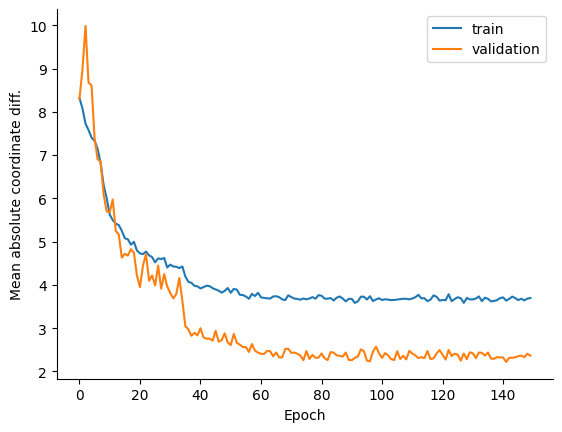

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['metric_abs'])
plt.plot(history.history["val_metric_abs"])
plt.legend(["train","validation"])
plt.xlabel('Epoch')
plt.ylabel('Mean absolute coordinate diff.')
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False) 
plt.show()

In [6]:
# load model
model = keras.models.load_model('./checkpoint_mdl_v2_rho32',
                                   custom_objects={'custom_loss': custom_loss,
                                                   'metric_abs': metric_abs})

In [9]:
sample_input, sample_output = next(iter(train_ds))
model_output = model(sample_input)

print(sample_output)
print(model_output)

2024-02-28 12:05:01.046104: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-28 12:05:01.099524: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-28 12:05:01.272922: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


tf.Tensor(
[[ 10.  20.  17.   0.   3.  16.   6.  32.]
 [-27. -18.  -6. -16.  29.  -5. -29. -28.]
 [-10. -31.  10. -14.  -5.  16. -10. -20.]
 [-15.  -6.  28. -17.  15.   8.  12.  15.]
 [-28.  13.   7.   3.  28.  22.  31.   9.]
 [ 19.  11.  -7. -20.   5. -19.  25. -27.]
 [-17. -31. -32. -19. -32.   1. -18.  18.]
 [ 12.   9.  25. -15. -19.  -6.  16. -15.]], shape=(8, 8), dtype=float32)
tf.Tensor(
[[  5.4661236   8.857923   15.062669   -2.3601642   4.4459395  12.144436
   18.215397   16.879765 ]
 [-18.687891   -3.941768    4.541521  -16.189926   40.818737   -2.2865148
  -16.82984    -3.4499886]
 [-17.844526  -29.359205   14.5044    -21.622234   -8.047634   12.951066
    0.5668522 -22.078863 ]
 [ -9.684166   -8.575508   25.801073  -10.253992   10.116131    8.79167
    8.170098    9.114516 ]
 [-31.665684    2.0188248  14.233522    8.259908   27.031252   19.635918
   27.786026    3.5576503]
 [ 12.330813    9.350094   -6.303658  -14.801803    9.159908  -16.298054
   13.831107  -15.582515 ]
 [-

In [7]:
model_saved.save_weights('./chkpt_weight/checkpoint_mdl_v2_rho32_weights')